In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
df = pd.read_json('/content/News_Category_Dataset_v3.json',lines = True,dtype=False)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [ ]:
print(len(df))
df.info()

209527
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [ ]:
df['category'].nunique()

42

In [ ]:
df['category']=df['category'].replace('THE WORLDPOST','WORLDPOST')

In [ ]:
df = df.drop_duplicates(subset=['short_description', 'headline', 'category'], keep='first')

category
POLITICS          35585
WELLNESS          17940
ENTERTAINMENT     17358
TRAVEL             9897
STYLE & BEAUTY     9681
PARENTING          8763
HEALTHY LIVING     6689
QUEER VOICES       6344
FOOD & DRINK       6340
WORLDPOST          6243
BUSINESS           5990
COMEDY             5390
SPORTS             5077
BLACK VOICES       4580
HOME & LIVING      4288
PARENTS            3897
WEDDINGS           3653
CRIME              3558
WOMEN              3487
IMPACT             3483
DIVORCE            3423
WORLD NEWS         3297
MEDIA              2942
WEIRD NEWS         2777
GREEN              2617
RELIGION           2570
STYLE              2247
SCIENCE            2206
TASTE              2096
TECH               2055
MONEY              1756
ARTS               1509
ENVIRONMENT        1443
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1338
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1073
EDUCATION          1014
Name: c

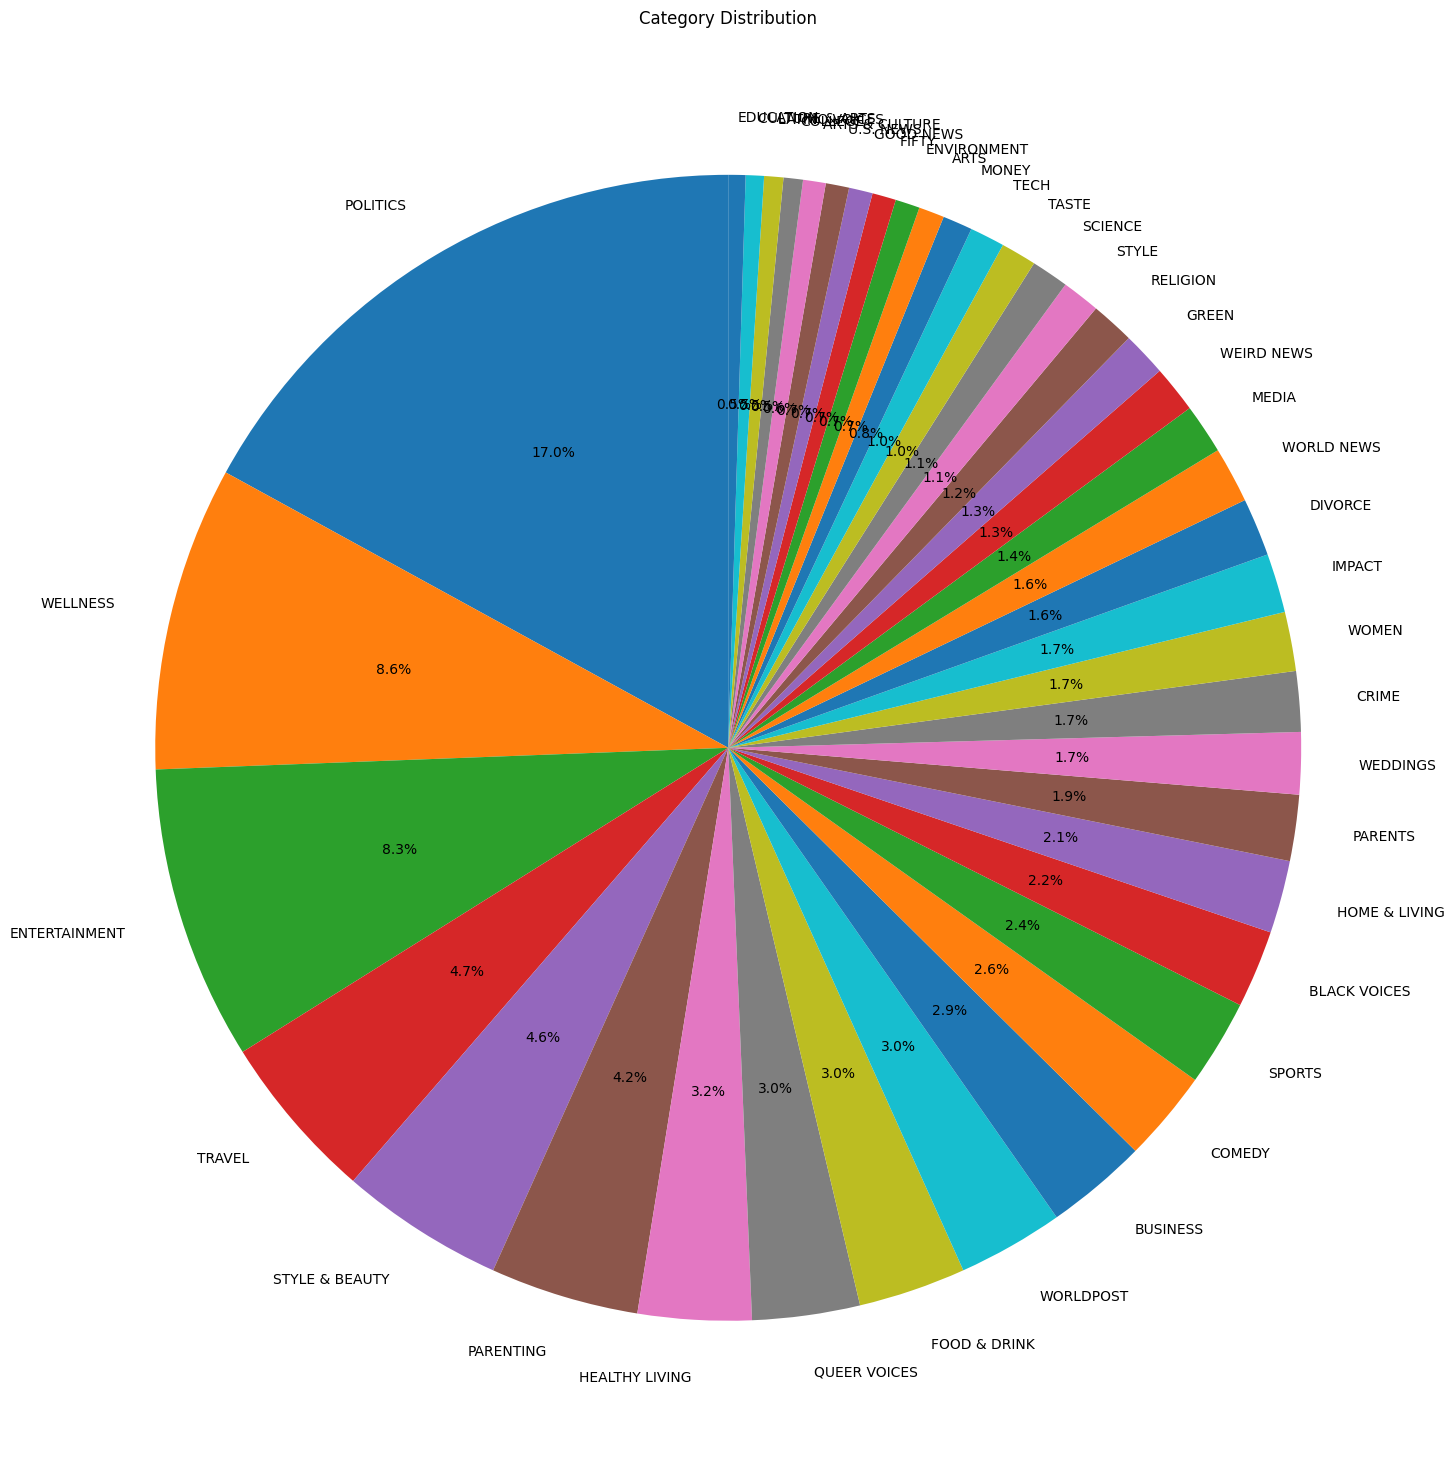

In [ ]:
category_counts = df['category'].value_counts()
print(category_counts)
plt.figure(figsize=(15, 15))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)

plt.title("Category Distribution")
plt.tight_layout()
plt.show()


In [ ]:
features = ['headline','category']
df[features].describe()

,headline,category
count,209056,209056
unique,207996,41
top,Sunday Roundup,POLITICS
freq,90,35585


In [ ]:
headline_counts=df['headline'].value_counts().reset_index()
duplicate_headlines=headline_counts[headline_counts['count']>1]['headline']
filtered_df = df[df['headline'].isin(duplicate_headlines)]
grouped = filtered_df.groupby('headline')['category'].nunique()
grouped.head()

,category
headline,
,6
"'CR Fashion Book,' Carine Roitfeld's New Magazine, Delivers 'Creativity,' Sideboob (PHOTOS)",1
'Fifty Shades Of Grey' Fashion Ads Were Kind Of Inevitable (PHOTO),1
"'The Boys,' 'Mortal Instruments' Dropped By Studios",1
"'The Week In Gay,' HuffPost Live Segment, Recaps Biggest LGBT Stories Of The Week",1


Có những headline trống, còn lại những headline cùng tên sẽ có cùng category

In [ ]:
grouped=grouped.reset_index()
null_headline=grouped[grouped['category']>1]['headline'][0]

In [ ]:
test = df[df['headline'] == null_headline]
test

,link,headline,category,short_description,authors,date
90944,https://www.huffingtonpost.com/entry/lincoln-2...,,POLITICS,,"Robert Moran, ContributorRobert Moran leads Br...",2015-08-22
95567,https://www.huffingtonpost.com/entry/post_9671...,,RELIGION,Let everyone not wrapped in tired and disprove...,"Matthew Fox, ContributorRadical theologian Mat...",2015-06-30
103675,https://www.huffingtonpost.com/entry/us-and-eu...,,WORLDPOST,,"Natasha Srdoc, ContributorAuthor, Economist, C...",2015-03-29
109100,https://www.huffingtonpost.com/entry/disney-ce...,,BUSINESS,,"Gary Snyder, ContributorWriter and Media Strat...",2015-01-25
110153,https://www.huffingtonpost.com/entry/beverly-h...,,MEDIA,,"Gary Snyder, ContributorWriter and Media Strat...",2015-01-13
122145,https://www.huffingtonpost.com/entry/beverly-h...,,QUEER VOICES,,"Gary Snyder, ContributorWriter and Media Strat...",2014-08-28


headline trống và cũng không có short_description nên không thể xử lý được những dòng này

In [ ]:
df_new = df[(df['headline'] != null_headline) & ((df['short_description'] != null_headline))]
df_new

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


In [ ]:
df_new['headline']=df_new['headline'].apply(lambda x: x.lower())
df_new['short_description']=df_new['short_description'].apply(lambda x: x.lower())

<ipython-input-14-90f87addcc00>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['headline']=df_new['headline'].apply(lambda x: x.lower())
<ipython-input-14-90f87addcc00>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['short_description']=df_new['short_description'].apply(lambda x: x.lower())


In [ ]:
df_new['short_description_len'] = df_new['short_description'].apply(lambda x: len(x.strip().split()))
df_new['headline_len'] = df_new['headline'].apply(lambda x: len(x.strip().split()))

<ipython-input-15-a343f14da5b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['short_description_len'] = df_new['short_description'].apply(lambda x: len(x.strip().split()))
<ipython-input-15-a343f14da5b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['headline_len'] = df_new['headline'].apply(lambda x: len(x.strip().split()))


In [ ]:
df_new.head()

,link,headline,category,short_description,authors,date,short_description_len,headline_len
0,https://www.huffpost.com/entry/covid-boosters-...,over 4 million americans roll up sleeves for o...,U.S. NEWS,health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,29,11
1,https://www.huffpost.com/entry/american-airlin...,"american airlines flyer charged, banned for li...",U.S. NEWS,he was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,28,13
2,https://www.huffpost.com/entry/funniest-tweets...,23 of the funniest tweets about cats and dogs ...,COMEDY,"""until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,12,13
3,https://www.huffpost.com/entry/funniest-parent...,the funniest tweets from parents this week (se...,PARENTING,"""accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,25,9
4,https://www.huffpost.com/entry/amy-cooper-lose...,woman who called cops on black bird-watcher lo...,U.S. NEWS,amy cooper accused investment firm franklin te...,Nina Golgowski,2022-09-22,25,11


In [ ]:
stats=['short_description_len','headline_len']
df_new[stats].describe()

,short_description_len,headline_len
count,209050.000000,209050.000000
mean,19.674901,9.602349
std,14.160973,3.069290
min,0.000000,1.000000
25%,10.000000,8.000000
50%,19.000000,10.000000
75%,24.000000,12.000000
max,243.000000,44.000000


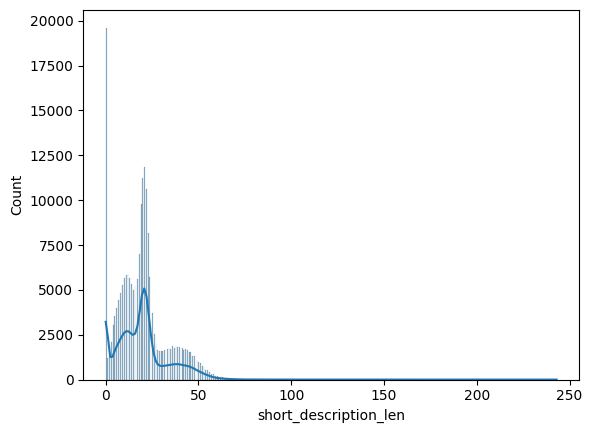

In [ ]:
sns.histplot(df_new['short_description_len'],kde=True)
plt.show()

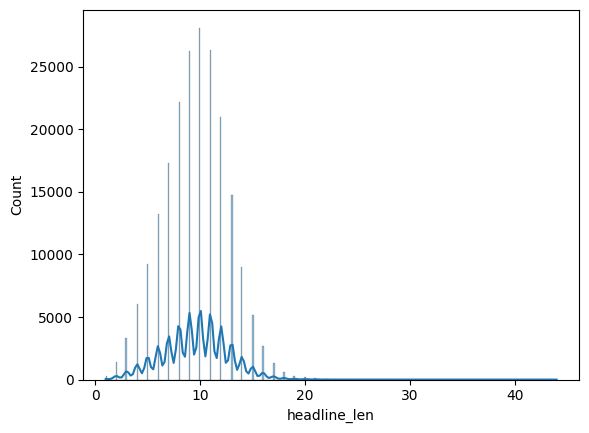

In [ ]:
sns.histplot(df_new['headline_len'],kde=True)
plt.show()

In [ ]:
df_new['description']= df_new['headline'] + ' ' + df_new['short_description']
df_new['description_len'] = df_new['short_description_len'] + df_new['headline_len']
df_new.head()

<ipython-input-20-6faf25dd0012>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['description']= df_new['headline'] + ' ' + df_new['short_description']
<ipython-input-20-6faf25dd0012>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['description_len'] = df_new['short_description_len'] + df_new['headline_len']


,link,headline,category,short_description,authors,date,short_description_len,headline_len,description,description_len
0,https://www.huffpost.com/entry/covid-boosters-...,over 4 million americans roll up sleeves for o...,U.S. NEWS,health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,29,11,over 4 million americans roll up sleeves for o...,40
1,https://www.huffpost.com/entry/american-airlin...,"american airlines flyer charged, banned for li...",U.S. NEWS,he was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,28,13,"american airlines flyer charged, banned for li...",41
2,https://www.huffpost.com/entry/funniest-tweets...,23 of the funniest tweets about cats and dogs ...,COMEDY,"""until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,12,13,23 of the funniest tweets about cats and dogs ...,25
3,https://www.huffpost.com/entry/funniest-parent...,the funniest tweets from parents this week (se...,PARENTING,"""accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,25,9,the funniest tweets from parents this week (se...,34
4,https://www.huffpost.com/entry/amy-cooper-lose...,woman who called cops on black bird-watcher lo...,U.S. NEWS,amy cooper accused investment firm franklin te...,Nina Golgowski,2022-09-22,25,11,woman who called cops on black bird-watcher lo...,36


Đặt headline lên trước short_description thay vì ngược lại vì có thể headline sẽ mang nhiều thông tin hơn. Lost in the middle.

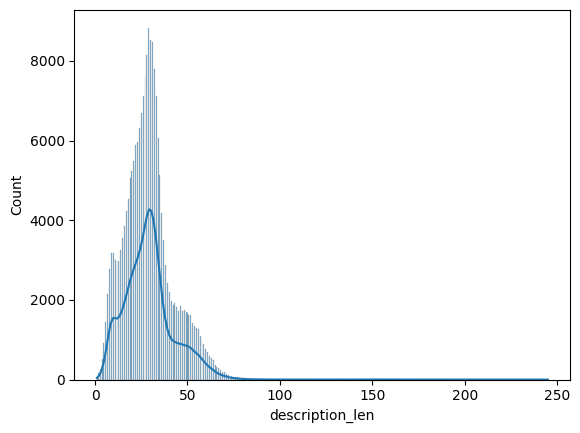

In [ ]:
sns.histplot(df_new['description_len'],kde=True)
plt.show()

Đặt headline lên trước short_description thay vì ngược lại vì có thể headline sẽ mang nhiều thông tin hơn. Lost in the middle.

In [ ]:
label_encoder = LabelEncoder()
df_new["label"] = label_encoder.fit_transform(df_new["category"])
num_classes = len(label_encoder.classes_)

<ipython-input-22-947543c7cb61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["label"] = label_encoder.fit_transform(df_new["category"])


In [ ]:
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(mapping)


{'ARTS': 0, 'ARTS & CULTURE': 1, 'BLACK VOICES': 2, 'BUSINESS': 3, 'COLLEGE': 4, 'COMEDY': 5, 'CRIME': 6, 'CULTURE & ARTS': 7, 'DIVORCE': 8, 'EDUCATION': 9, 'ENTERTAINMENT': 10, 'ENVIRONMENT': 11, 'FIFTY': 12, 'FOOD & DRINK': 13, 'GOOD NEWS': 14, 'GREEN': 15, 'HEALTHY LIVING': 16, 'HOME & LIVING': 17, 'IMPACT': 18, 'LATINO VOICES': 19, 'MEDIA': 20, 'MONEY': 21, 'PARENTING': 22, 'PARENTS': 23, 'POLITICS': 24, 'QUEER VOICES': 25, 'RELIGION': 26, 'SCIENCE': 27, 'SPORTS': 28, 'STYLE': 29, 'STYLE & BEAUTY': 30, 'TASTE': 31, 'TECH': 32, 'TRAVEL': 33, 'U.S. NEWS': 34, 'WEDDINGS': 35, 'WEIRD NEWS': 36, 'WELLNESS': 37, 'WOMEN': 38, 'WORLD NEWS': 39, 'WORLDPOST': 40}


In [ ]:
from transformers import AutoTokenizer, BertForSequenceClassification, AdamW
model_name = 'bert-base-uncased'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
tokenizer = AutoTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
df_new['tokenizer_len'] = df_new['description'].apply(lambda x: len(tokenizer(x,padding=True, truncation=False, return_tensors="pt").input_ids[0]))

<ipython-input-24-6223ce250cc6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['tokenizer_len'] = df_new['description'].apply(lambda x: len(tokenizer(x,padding=True, truncation=False, return_tensors="pt").input_ids[0]))


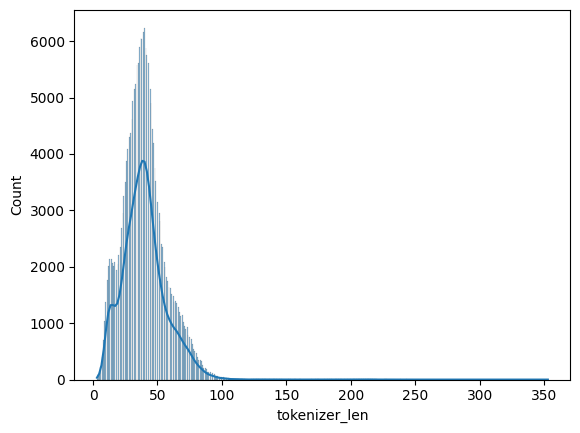

In [ ]:
sns.histplot(df_new['tokenizer_len'],kde=True)
plt.show()

Không bị vượt quá 512 tokens (số lượng tối đa của mô hình)

In [ ]:
class CreateDataset(Dataset):
    def __init__(self,texts,labels,tokenizer,max_length=75):
        self.max_length=max_length
        self.tokenizer=tokenizer
        self.texts=texts
        self.labels=labels
        self.len=len(texts)
    def __len__(self):
        return self.len
    def __getitem__(self,idx):
        description=self.texts[idx]
        label=self.labels[idx]
        encoding = self.tokenizer(
            description,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_new["description"], df_new["label"], test_size=0.2, random_state=42
)

train_dataset = CreateDataset(train_texts.tolist(), train_labels.tolist(), tokenizer)
val_dataset = CreateDataset(val_texts.tolist(), val_labels.tolist(), tokenizer)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
label_counts = df_new['label'].value_counts().sort_index()
total_samples = len(df_new)
num_classes = len(label_counts)

weights = total_samples / (num_classes * label_counts)
print(weights)

Trọng số cho từng lớp:
label
0     3.378914
1     3.810748
2     1.113271
3     0.851358
4     4.456976
5     0.945970
6     1.433047
7     4.751892
8     1.489565
9     5.028383
10    0.293742
11    3.533458
12    3.639387
13    0.804224
14    3.647196
15    1.948330
16    0.762263
17    1.189081
18    1.463905
19    4.512195
20    1.733689
21    2.903634
22    0.581853
23    1.308386
24    0.143289
25    0.803844
26    1.984734
27    2.311324
28    1.004290
29    2.269150
30    0.526679
31    2.432624
32    2.481158
33    0.515184
34    3.702818
35    1.395779
36    1.836075
37    0.284213
38    1.462226
39    1.546491
40    0.816850
Name: count, dtype: float64


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
weights_tensor = torch.tensor(weights.values, dtype=torch.float)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights_tensor)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids,labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_train_loss = total_loss / len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}")

100%|██████████| 1307/1307 [33:49<00:00,  1.55s/it]

Epoch 1/1
Train Loss: 0.6364


In [ ]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader):
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 327/327 [03:04<00:00,  1.77it/s]


In [ ]:
from sklearn.metrics import classification_report
cm = classification_report(all_labels, all_preds)
print(cm)

              precision    recall  f1-score   support

           0       0.46      0.65      0.54       306
           1       0.51      0.58      0.54       268
           2       0.58      0.51      0.55       924
           3       0.59      0.61      0.60      1242
           4       0.49      0.56      0.52       232
           5       0.69      0.55      0.61      1075
           6       0.66      0.63      0.64       725
           7       0.69      0.48      0.56       224
           8       0.85      0.83      0.84       698
           9       0.52      0.55      0.53       202
          10       0.76      0.80      0.78      3501
          11       0.62      0.51      0.56       301
          12       0.48      0.42      0.45       271
          13       0.80      0.75      0.77      1281
          14       0.50      0.34      0.41       268
          15       0.46      0.56      0.51       554
          16       0.57      0.49      0.52      1303
          17       0.87    

In [ ]:
torch.save(model.state_dict(), "trained_model.pt")
